In [2]:
import numpy as np
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
import scipy.integrate as integrate
from scipy.optimize import fsolve
from scipy.stats import norm
from numpy.linalg import inv
import scipy.stats as stat
# import SSTL_perf

Notations <br>
$n$: total number of data points <br>
$p$: dimension of each data point
$T$: number of task
$\Gamma $: matrix of correlation between tasks <br>
$\lambda_t$: proportion of labeled data in task $ t$ <br>
$\rho_t$: proportion of data with label 1 in task $t$ <br>
$\alpha_t$: number of points in task $ t$ is $\alpha_t p$ <br>
$\sigma$: each gaussian cluster has covariance $ \sigma I_p$, the quantity $1/\sigma^2$ is call signal-to-noise ratio (SNR) <br>

Let $ p_t, q_t$ be the solution of
$$
q_t = [\Gamma - \Gamma(I+D \Gamma)^{-1}]_{tt} \\
p_t = \lambda_t + (1-\lambda_t)F(\rho_t, q_t/\sigma^2)
$$
where
$$
D = diag[\alpha_1 p_1/\sigma^2, \dots, \alpha_T p_T/\sigma^2]\\
F(\rho, \gamma) = - 1 + 2\partial_{\gamma} \mathbb{E} \left[ \rho \log \left( \rho e^{\sqrt{\gamma} Z - \gamma} + (1-\rho) e^{-\sqrt{\gamma}Z+\gamma} \right) + (1-\rho)\log \left( \rho e^{\sqrt{\gamma} Z + \gamma} + (1-\rho) e^{-\sqrt{\gamma}Z-\gamma} \right) \right]
$$
The error of task $t$ is
$$
1-\phi(\sqrt{q_t}/\sigma)
$$

In [3]:
def inv(A):
    return np.linalg.inv(A)

# calculation f'(x) with error O(h^2)
def diff(f, x, h):
    return (3*f(x)-4*f(x+h)+f(x+2*h))/(-2*h)

# compute E[f(Z)] where Z ~ N(0,1)
def EZ(f):
    return 1/np.sqrt(2*np.pi)*integrate.quad(lambda z: np.exp(-z**2/2)*f(z), -6, 6)[0] 

# calculate F(rho, gamma) (which is f3)
def f1(rho, gam, z):
    return rho*np.log(rho*np.exp(np.sqrt(gam)*z-gam)+(1-rho)*np.exp(-np.sqrt(gam)*z+gam)) +\
       (1-rho)*np.log(rho*np.exp(np.sqrt(gam)*z+gam)+(1-rho)*np.exp(-np.sqrt(gam)*z-gam))

def f2(rho, gam, z):
    return diff(lambda x: f1(rho, x, z), gam, 0.0001)

def f3(rho, gam):
    return -1 + 2*EZ(lambda z: f2(rho, gam, z))

In [4]:
T=2 #number of tasks

# calculate the overlaps q1, q2, p1, p2
def solve(l1, l2, al1, al2, rho1, rho2, snr, Gam):
    def eqs(vec):
        p1,p2,q1,q2 = vec[0], vec[1], vec[2], vec[3]
        I = np.identity(2)
        return [p1-l1-(1-l1)*f3(rho1, q1*snr),
                p2-l2-(1-l2)*f3(rho2, q2*snr),
                q1 - Gam[0,0]+ (Gam@inv(I + np.diag([al1*p1*snr, al2*p2*snr])@Gam))[0,0],
                q2 - Gam[1,1]+ (Gam@inv(I + np.diag([al1*p1*snr, al2*p2*snr])@Gam))[1,1] ]
    return fsolve(eqs, [0.5, 0.5, 0.5, 0.5])  

In [5]:
p = 100
nl = 100
nu = 0
rho_l = np.array([[0.3,0.2],[0.25,0.25]])#rho_l[0,0]/(rho_l[0,0]+rho_l[0,1])==rho_u[0,0]/(rho_u[0,0]+rho_u[0,1])
rho_u = np.array([[0.3,0.2],[0.25,0.25]])#rho_l[1,0]/(rho_l[1,0]+rho_l[1,1])==rho_u[1,0]/(rho_u[1,0]+rho_u[1,1])
if rho_l[0,0]/(rho_l[0,0]+rho_l[0,1])!=rho_u[0,0]/(rho_u[0,0]+rho_u[0,1]):
    print("Error in task 1")
if rho_l[1,0]/(rho_l[1,0]+rho_l[1,1])!=rho_u[1,0]/(rho_u[1,0]+rho_u[1,1]):
    print("Error in task 2")

In [36]:
l1 = nl*np.sum(rho_l[0])/(nl*np.sum(rho_l[0])+nu*np.sum(rho_u[0]))
l2 = nl*np.sum(rho_l[1])/(nl*np.sum(rho_l[1])+nu*np.sum(rho_u[1]))
al1 = (nl*np.sum(rho_l[0])+nu*np.sum(rho_u[0]))/p
al2 = (nl*np.sum(rho_l[1])+nu*np.sum(rho_u[1]))/p
rho1 = rho_l[0,0]/np.sum(rho_l[0])
rho2 = rho_l[1,0]/np.sum(rho_l[1])
snr = 1
print(al2)

0.5


In [24]:
gams = np.linspace(0.01, 0.99, 10)
sols = [solve(l1, l2, al1, al2, rho1, rho2, snr, np.array([[1, gam],[gam, 1]])) for gam in gams]

/home/sami/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [40]:
mu = np.random.multivariate_normal(np.zeros(p),np.eye(p))#/np.sqrt(p)
mu /= np.linalg.norm(mu)
mu_tilde = np.random.multivariate_normal(np.zeros(p),np.eye(p))
mu_ortho = mu_tilde - np.dot(mu,mu_tilde)*mu
mu_ortho /= np.linalg.norm(mu_ortho)
MU = np.zeros((T,2,p))
E1 = []
E2 = []
for gam in gams:
    MU[0,0] = -mu
    MU[0,1] = mu
    MU[1,0] = -(gam*mu + np.sqrt(1-gam**2)*mu_ortho)
    MU[1,1] = gam*mu + np.sqrt(1-gam**2)*mu_ortho

for i in range(2):
    for j in range(2):
        print(f"MU[{i}][{j}] = {MU[i,j]}")
#     E1.append(SSTL_perf.test_perf(p,nl,nu,rho_l,rho_u,gam,0,MU))
#     E2.append(SSTL_perf.test_perf(p,nl,nu,rho_l,rho_u,1,1,MU))
# E1 = np.array(E1)
# E2 = np.array(E2)
# E1_naive, E1_opt, E1_alpha = (rho_u[0,0]*E1[:,2]+rho_u[0,1]*E1[:,3])/np.sum(rho_u[0]), (rho_u[0,0]*E1[:,6]+rho_u[0,1]*E1[:,7])/np.sum(rho_u[0]), (rho_u[0,0]*E1[:,10]+rho_u[0,1]*E1[:,11])/np.sum(rho_u[0])
# E2_naive, E2_opt, E2_alpha = (rho_u[1,0]*E2[:,2]+rho_u[1,1]*E2[:,3])/np.sum(rho_u[1]), (rho_u[1,0]*E2[:,6]+rho_u[1,1]*E2[:,7])/np.sum(rho_u[1]), (rho_u[1,0]*E2[:,10]+rho_u[1,1]*E2[:,11])/np.sum(rho_u[1])

MU[0][0] = [ 0.02993211 -0.15839194  0.06646006  0.04603509 -0.08880028  0.03150219
 -0.22090273 -0.12081144  0.01248615 -0.10647655 -0.1521706  -0.03142799
  0.19069753 -0.16770682  0.09465905 -0.11005345  0.17352647 -0.0981511
 -0.08263854  0.07034782  0.01190856  0.0729596  -0.01492945 -0.06596391
 -0.03128804  0.02436265  0.02240834  0.02209916 -0.01782305  0.14525012
  0.02519013 -0.08868027 -0.02156829  0.02153778  0.00103459 -0.10317606
  0.18040189  0.08941142 -0.01143003  0.23867695  0.04442674 -0.02568037
 -0.19316926  0.03895849  0.0290527  -0.01185464  0.07573261 -0.06496643
  0.04005629 -0.07913027  0.02439932 -0.00475012 -0.09505636  0.11888735
  0.13023752 -0.13756928  0.00122922 -0.05284692 -0.05449404 -0.11411563
  0.07101808  0.13340024 -0.10671013  0.00465315  0.05503485 -0.02187191
  0.10330394 -0.01861624  0.11293935 -0.14327871  0.07491196  0.19456836
 -0.04210168 -0.03728157  0.02238086  0.02901932 -0.17554793  0.00411184
 -0.07508055  0.15236453 -0.09352949  0.0

In [39]:
q1s = [sol[2] for sol in sols]
print(q1s)
r1s = [1-rho1*norm.cdf(np.sqrt(q1)-np.log((1-rho1)/rho1)/(2*np.sqrt(q1)))-(1-rho1)*norm.cdf(np.sqrt(q1)+np.log((1-rho1)/rho1)/(2*np.sqrt(q1))) for q1 in q1s]
print(r1s)

q2s = [sol[3] for sol in sols]
r2s = [1-rho2*norm.cdf(np.sqrt(q2)-np.log((1-rho2)/rho2)/(2*np.sqrt(q2)))-(1-rho2)*norm.cdf(np.sqrt(q2)+np.log((1-rho2)/rho2)/(2*np.sqrt(q2))) for q2 in q2s]

[0.333348148312759, 0.3354306372243597, 0.34106422828445193, 0.35033927274227655, 0.36340702510899175, 0.3804859225232103, 0.40187097854488385, 0.4279470689990782, 0.45920727513908643, 0.49627800845397063]
[0.2701495794133345, 0.26958960148202504, 0.2680852392456289, 0.26564121257018747, 0.2622646420048801, 0.25796429818061845, 0.25274966556761214, 0.24662990275991853, 0.23961278417661003, 0.23170370441707866]


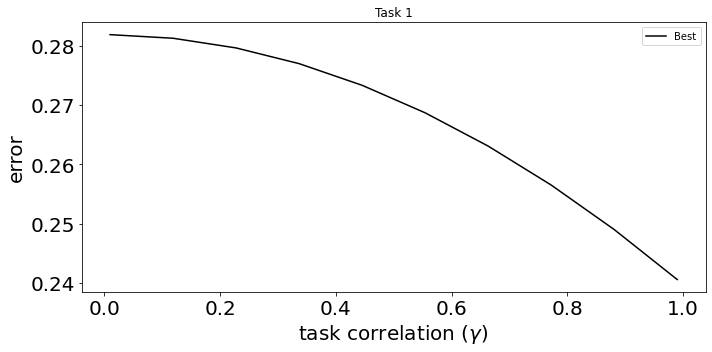

In [29]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
plt.title("Task 1")
#plt.axis((0,1,0.21,0.28))
ax.plot(gams, r2s, label = 'Best', color = 'black')
# ax.plot(gams, E1_naive, label = 'Naive', color='blue')
# ax.plot(gams, E1_opt, label = 'Opti', color='red')
# ax.plot(gams, E1_alpha, label = 'Alpha opti', color='green')

ax.set_xlabel(r'task correlation ($\gamma$)', fontsize=20)
ax.set_ylabel(r'error', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
plt.legend()
plt.show()

NameError: name 'E2_naive' is not defined

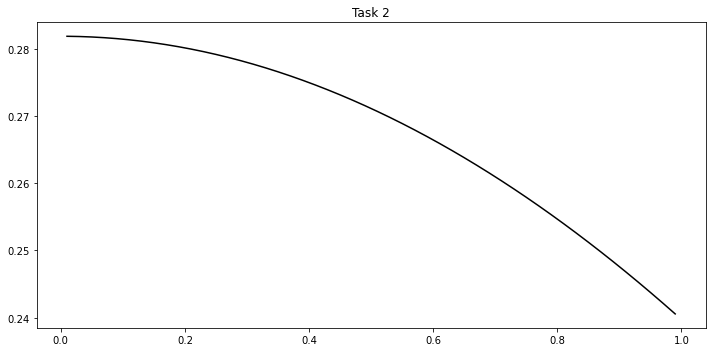

In [21]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
plt.title("Task 2")
#plt.axis((0,1,0.21,0.28))
ax.plot(gams, r1s, label = 'Best', color = 'black')
ax.plot(gams, E2_naive, label = 'Naive', color='blue')
ax.plot(gams, E2_opt, label = 'Opti', color='red')
ax.plot(gams, E2_alpha, label = 'Alpha opti', color='green') 

ax.set_xlabel(r'task correlation ($\gamma$)', fontsize=20)
ax.set_ylabel(r'error', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
plt.legend()
plt.show()

# Unsupervised learning and Phase transition

In [13]:
# unsupervised case
l1 = 0
l2 = 0
al1 = 1
al2 = 1
rho1 = 0.5
rho2 = 0.5
gam = 0 
Gam = np.array([[1, gam],[gam, 1]])

<font color='red'>  The error when running fsolve might be eliminated when the search for the solution is restricted in the domain $[0,1]^4$ but it seems that fsolve does not support solving an equation over a domain </font>

In [14]:
# unsupervised learning, error vs snr
snrs = np.linspace(0.01, 5, 50)
sols = [solve(l1, l2, al1, al2, rho1, rho2, snr, Gam) for snr in snrs]

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.


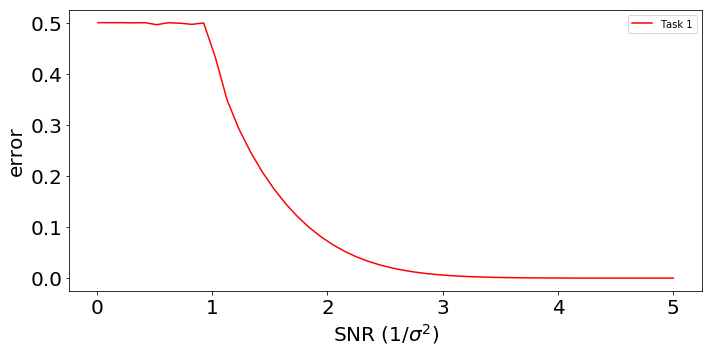

In [15]:
qs = [sol[2] for sol in sols]
risks = [1-norm.cdf(np.sqrt(qs[i])*snrs[i]) for i in range(len(qs))]

fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
ax.plot(snrs, risks, label = 'Task 1', color = 'red')

ax.set_xlabel(r'SNR ($1/\sigma^2$)', fontsize=20)
ax.set_ylabel(r'error', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
plt.legend()
plt.show()